### Notebook to evaluate plates via Abaqus

This notebooks provides a workflow to:
1. Impose a beading pattern on a rectangular plate
2. Define the point force position and the rotational stiffness boundary condition
3. Perform the FE simulation using Abaqus
4. Exract the mean squared velocity per frequency step
5. Plot the results
<br><br>
**Requirements:**
- You need to be able to call abaqus via the terminal (Try "abaqus info=release")
- Tested with Abaqus 2018



### Setup

In [1]:
import subprocess
sim_name = "my_beading"                                     
tamplate_inp = "configs/fem/plate_template.inp"       # template inp file   

### Load plate beading pattern and model properties

For demonstration purpose we load a beading pattern from the test dataset. <br>
These data should be replaced with your individual beading plates.

[43.043716    0.5688745   0.41522002]
0.511987030506134
0.24913201332092283


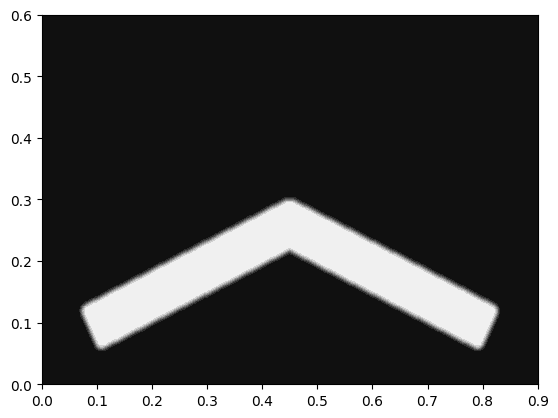

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import hdf5plugin

sample = 34

with h5py.File('D500_edit.h5', 'r') as f:           # Adjust the path to where you stored the test dataset
    beading = f['bead_patterns'][sample]
    phy_para = f['phy_para'][sample]
    freqs_ref = f['frequencies'][sample]
    z_vel_mean_sq_ref = f['z_vel_mean_sq'][sample]

cT = phy_para[0]
fx = phy_para[1] * 0.9
fy = phy_para[2] * 0.6

print(phy_para)
print(fx)
print(fy)

x_grid = np.linspace(0.0, 0.9, 181)
y_grid = np.linspace(0.0, 0.6, 121)
xx, yy = np.meshgrid(x_grid, y_grid)

fig, ax = plt.subplots()
ax.contourf(xx, yy, beading, cmap = "grey")

### Write beading pattern to inp file

In [3]:
import shutil,os
from plate_optim.utils.abaqus_helper import write_beading_to_inp

os.makedirs(sim_name, exist_ok=True)
inp_path = f"{sim_name}/plate_sim.inp"
shutil.copy(tamplate_inp, inp_path)
write_beading_to_inp(inp_file= inp_path, beading_img= beading)

### Set force poistion

In [4]:
from plate_optim.utils.abaqus_helper import get_node_id, replace_line
f_pos = [fx, fy]

f_node_id = get_node_id(inp_path, f_pos)
replace_line(inp_path, key = "*Nset, nset=ExcitationPoint", replacement=f"{int(f_node_id)},", skip_lines = 1)

### Set BC

In [5]:
replace_line(inp_path, key = "*Spring, elset=Springs_rx-spring", replacement=f"{cT:.2f}", skip_lines = 2)
replace_line(inp_path, key = "*Spring, elset=Springs_ry-spring", replacement=f"{cT:.2f}", skip_lines = 2)

### Set frequency range and intermediate steps

In [6]:
f_min = 1.0
f_max = 300.0
steps_between_resonances = 25
bias = 2                            # How the frequency steps are distributed 

command = f"{f_min:.1f}, {f_max:.1f}, {steps_between_resonances}, {bias:.1f}"
replace_line(inp_path, key = "*Steady State Dynamics", replacement=command, skip_lines = 1)

### Simulate via Abaqus API

Takes around 1 miniute on a laptop

In [7]:
wdir = os.getcwd()
os.chdir(sim_name)
command = f'abaqus job=plate_sim'
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
os.chdir(wdir)

# Capture the output and error
stdout, stderr = process.communicate()
print("Output:", stdout)
print("Error:", stderr)


Output: b''
Error: b''


### Open .odb file and write velocity field to .txt file

Takes around 2 minutes on a laptop

In [8]:
import subprocess

command = f'abaqus cae noGui=plate_optim/utils/abaqus_extract_velocity.py -- {inp_path}'
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
print("Output:", stdout)
print("Error:", stderr)


Output: b''
Error: b'Abaqus License Manager checked out the following license:\r\n"cae" from Flexnet server gitzlicabq.tu-bs.de\r\n<10 out of 25 licenses remain available>.\r\n'


### Plot the frequency response

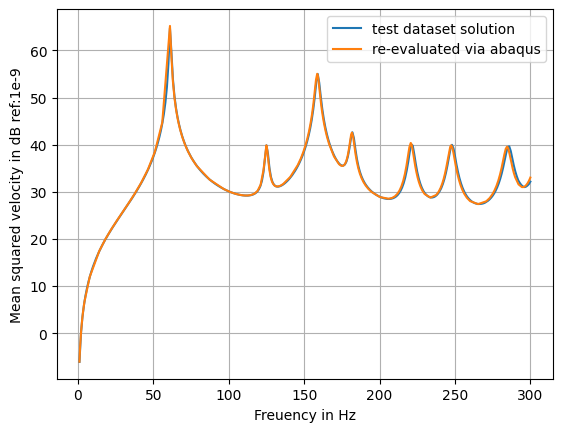

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# Load Abaqus Result 181 x 121
abaqus_file = f"{sim_name}/Velocity_AllNodes.txt"
f_steps = []
z_vel = []

with open(abaqus_file, 'r') as file:
    file.readline()
    for line in file:
        values = line.split()
        row = [float(value) for value in values]
        f_steps.append(row[0])
        z_vel.append(row[3])

f_steps = np.array(f_steps)
z_vel = np.array(z_vel)

v_ref = 1e-9
z_vel_dB = 10 * np.log10(z_vel / v_ref)

fig, ax = plt.subplots()
ax.plot(freqs_ref, z_vel_mean_sq_ref, label = "test dataset solution")
ax.plot(f_steps, z_vel_dB, label = "re-evaluated via abaqus")
ax.grid(True)
ax.set_xlabel("Freuency in Hz")
ax.set_ylabel("Mean squared velocity in dB ref:1e-9")
ax.legend()